In [158]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [2]:
def buffer(x: np.ndarray):
    return x

def inverter(x: np.ndarray):
    return np.logical_not(x)

def AND(x: np.ndarray):
    return np.logical_and(x[0], x[1])
    
def NAND(x: np.ndarray):
    return np.logical_not(np.logical_and(x[0], x[1]))

def OR(x: np.ndarray):
    return np.logical_or(x[0], x[1])
    
def NOR(x: np.ndarray):
    return np.logical_not(np.logical_or(x[0], x[1]))

In [3]:
basics = {
    'BUF': buffer,
    'INV': inverter,
    'AND': AND,
    'NAND': NAND,
    'OR': OR,
    'NOR': NOR,
    # 'INPUT' = INPUT,
    # 'OUTPUT' = OUTPUT
}

In [188]:
class Circuit:
    
    # initialize the circuit
    # :param file: a file detailing the circuit gates, nodes, and I/O
    def __init__(self, file):
        self.parse(file)
        self.file = file
    
    # parse the input file
    def parse(self, file):
        # open file
        with open(file) as f:
            circuit = f.read()
            
        # double spaces are annoying
        circuit.replace('  ', ' ')
        
        # create an empty dictionary
        self.circuit = {}
        
        # iterate over each line in the file (each gate or input/output)
        for i, element in enumerate(circuit.split('\n')):
            # ignore empty strings/lines
            if element == '':
                continue
            # split the line into each of its components
            info = element.split(' ')
            
            # if the first element is input or output, uses a slightly different format
            # {INPUT: [1, 2, 3...]}
            if info[0] in ['INPUT', 'OUTPUT']:
                self.circuit.update({info[0]: list(map(int, info[2:]))})
            # else use this format
            # {GATE_#: {IN: [1, 2], OUT: [3]}}
            else:
                self.circuit.update({info[0]+f'_{i}': {'IN': list(map(int, info[1:-1])), 'OUT': int(info[-1])}})
        
        # find the largest number in the file
        self.length = 0
        for line in circuit.split('\n'):
            for num in line.split(' '):
                try:
                    num = int(num)
                    if num > self.length:
                        self.length = num
                except:
                    continue
        # add two for direct indexing
        # i.e. index 0 and -1 are ignored
        self.length+=2
            
    # simulate the circuit until steady state is reached
    def simulate(self, input_vector):
        # initialize the circuit with all 0s
        self.start = np.asarray([0]*self.length)
        self.next = np.copy(self.start)
        
        print('Input: ' + input_vector)
        # add the input values
        for i, index in zip(input_vector[:], self.circuit['INPUT']):
            self.next[index] = int(i)
        # print(self.next[1:])
        
        print(self.start)
        print(len(self.start))
        # while not in a steady state, continue looping over the gates in the circuit
        while not np.array_equal(self.start, self.next):
            self.start = np.copy(self.next)
            for element in self.circuit.keys():
                if element in ['INPUT', 'OUTPUT']:
                    continue
                self.next[self.circuit[element]['OUT']] = basics[element.split('_')[0]](self.start[self.circuit[element]['IN']])
            # print(self.next[1:])
        print('Output: ', ''.join([str(a) for a in self.next[self.circuit['OUTPUT']][:-1]]))
        return self.next[self.circuit['OUTPUT'][:-1]]
    
    def _parse_faults(self, file):
        with open(file) as f:
            lines = [line.rstrip() for line in f]
        faults = [line.split(' ') for line in lines[1:]]
        return np.asarray(faults, dtype=int)[:, 0].tolist(), np.asarray(faults, dtype=int)[:, 1].tolist()
    
    def simulate_faults(self, input_vector, file=None, fault_nodes=None, fault_values=None, verbose=True):
        if file is not None:
            fault_nodes, fault_values = self._parse_faults(file)
        
        if fault_nodes is None and file is None:
            fault_nodes = list(range(self.length))

        if fault_values is None and file is None:
            fault_values = [0, 1]*len(fault_nodes)
            fault_nodes = fault_nodes*2
            fault_nodes.sort()
        
        self.fault_values = fault_values
        self.fault_nodes = fault_nodes
        
        # initialize N copies of the circuit with all 0s
        # each row is N copies of that node
        self.start = np.zeros((self.length, len(fault_values)))       
        self.next = np.copy(self.start)
        
        if verbose:
            print('Input: ' + input_vector)
        # add the input values
        for i, index in zip(input_vector[:], self.circuit['INPUT']):
            self.next[index, :] = int(i)
        # print(self.next[1:])
                
        # add the faults into the initial state
        for i, (node, value) in enumerate(zip(fault_nodes, fault_values)):
            self.next[node, i] = value
        
        # while not in a steady state, continue looping over the gates in the circuit
        while not np.array_equal(self.start, self.next):
            self.start = np.copy(self.next)
            for element in self.circuit.keys():
                if element in ['INPUT', 'OUTPUT']:
                    continue
                self.next[self.circuit[element]['OUT']] = basics[element.split('_')[0]](self.start[self.circuit[element]['IN']])
                # reset faults
                for i, (node, value) in enumerate(zip(fault_nodes, fault_values)):
                    self.next[node, i] = value
            # print(self.next[1:])
        outputs = [''.join([str(int(a)) for a in self.next[self.circuit['OUTPUT'], n][:-1]]) for n in range(len(fault_nodes))]
        with open(f'fault_analysis_{self.file.split("/")[1]}', 'a') as f:
            f.write(f'Circuit: {self.file}\nInput Vector: {input_vector}\nFault-Free Output: {outputs[-1]}\n')
            count = 0
            for z, output in enumerate(outputs[:-1]):
                if output != outputs[-1]:
                    count += 1
            f.write(f'FAULTS DETECTED: {count} ({int(100*count/(len(fault_nodes)-4))}%)\n')
            for z, output in enumerate(outputs[:-1]):
                if output != outputs[-1]:
                    f.write(f'    {int(fault_nodes[z])} stuck at {int(fault_values[z])}\n')
            f.write('\n')
        if verbose:
            print('Fault-Free Output: ', ''.join([str(int(a)) for a in self.next[self.circuit['OUTPUT'], -1][:-1]]))
        return self.next[self.circuit['OUTPUT'][:-1]]

In [ ]:
def generate_vector(n):
    return format(random.getrandbits(n), f'#0{int(n+2)}b')[2:]

In [263]:
file = 'Circuit Inputs/s27.txt'
c = Circuit(file)

In [264]:
tests = ['1101101', '0101001']
# tests = ['1110101']
for test in tests:
    c.simulate_faults(test)

Input: 1101101
Fault-Free Output:  1011
Input: 0101001
Fault-Free Output:  0011


In [265]:
coverages = None
n=39

for _ in range(100):
    faults = []
    coverage = [0]
    if os.path.isfile('fault_analysis_s27.txt'):
        os.remove('fault_analysis_s27.txt')

    for _ in range(n):
        c.simulate_faults(generate_vector(7), verbose=False)
        with open('fault_analysis_s27.txt') as f:
            lines = [line.rstrip() for line in f]
        for line in lines:
            if 'stuck at' in line:
                fault = (int(line[:line.index('stuck at')].replace(' ', '')), int(line[line.index('stuck at')+8:].replace(' ', '')))
                if fault not in faults:
                    faults.append(fault)
        coverage.append(len(faults)/(2*c.length-4))
        # print(len(faults))

    if coverages is None:
        coverages = np.array(coverage).reshape(1, n+1)
    else:
        coverages = np.vstack((coverages, coverage))
    

In [270]:
coverages_27 = coverages

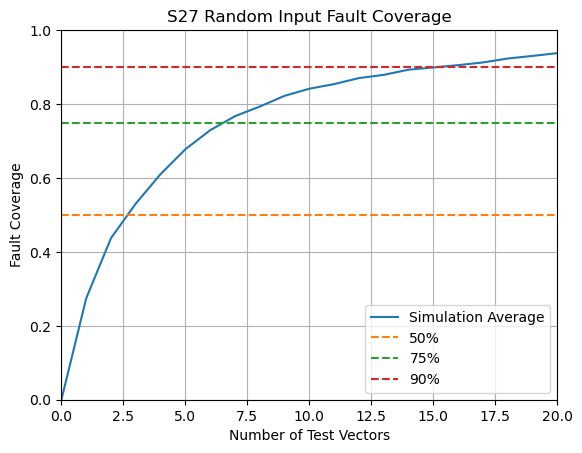

In [271]:
fig = plt.figure()
plt.plot(np.mean(coverages_27, axis=0), label='Simulation Average')
plt.plot(np.linspace(0, 41, 100), np.full((100), 0.5), linestyle='--', label='50%') 
plt.plot(np.linspace(0, 41, 100), np.full((100), 0.75), linestyle='--', label='75%') 
plt.plot(np.linspace(0, 41, 100), np.full((100), 0.9), linestyle='--', label='90%') 
plt.legend()
plt.grid(True)
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.xlabel('Number of Test Vectors')
plt.ylabel('Fault Coverage')
plt.title('S27 Random Input Fault Coverage')
plt.savefig('images/s27_faultcoverage.png')

In [306]:
file = 'Circuit Inputs/s298f_2.txt'
c = Circuit(file)
# print(c.circuit)

In [273]:
tests = ['10101011110010101', '11101110101110111']
# tests = ['10101010101010101']
for test in tests:
    c.simulate_faults(test)

Input: 10101011110010101
Fault-Free Output:  00000011110000101101
Input: 11101110101110111
Fault-Free Output:  00000000000000111010


In [274]:
coverages = None
n=50

for x in range(30):
    print(x)
    faults = []
    coverage = [0]
    if os.path.isfile('fault_analysis_s298f_2.txt'):
        os.remove('fault_analysis_s298f_2.txt')

    for _ in range(n):
        c.simulate_faults(generate_vector(17), verbose=False)
        with open('fault_analysis_s298f_2.txt') as f:
            lines = [line.rstrip() for line in f]
        for line in lines:
            if 'stuck at' in line:
                fault = (int(line[:line.index('stuck at')].replace(' ', '')), int(line[line.index('stuck at')+8:].replace(' ', '')))
                if fault not in faults:
                    faults.append(fault)
        coverage.append(len(faults)/(2*c.length-4))
        # print(len(faults))

    if coverages is None:
        coverages = np.array(coverage).reshape(1, n+1)
    else:
        coverages = np.vstack((coverages, coverage))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [275]:
coverages_298 = coverages

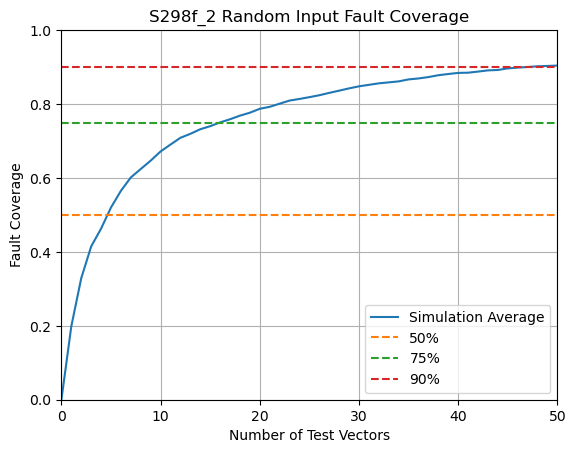

In [276]:
fig = plt.figure()
plt.plot(np.mean(coverages_298, axis=0), label='Simulation Average')
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.5), linestyle='--', label='50%') 
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.75), linestyle='--', label='75%') 
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.9), linestyle='--', label='90%') 
plt.legend()
plt.grid(True)
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.xlabel('Number of Test Vectors')
plt.ylabel('Fault Coverage')
plt.title('S298f_2 Random Input Fault Coverage')
plt.savefig('images/s298f_2_faultcoverage.png')

In [308]:
file = 'Circuit Inputs/s344f_2.txt'
c = Circuit(file)
# print(c.circuit)

In [278]:
tests = ['101010101010111101111111', 
         '111010111010101010001100', ]
# tests = ['101010101010101011111111']
for test in tests:
    c.simulate_faults(test)

Input: 101010101010111101111111
Fault-Free Output:  00011110101011101010101101
Input: 111010111010101010001100
Fault-Free Output:  00010101110010101010100010


In [279]:
coverages = None
n=50

for x in range(30):
    print(x)
    faults = []
    coverage = [0]
    if os.path.isfile('fault_analysis_s344f_2.txt'):
        os.remove('fault_analysis_s344f_2.txt')

    for _ in range(n):
        c.simulate_faults(generate_vector(17), verbose=False)
        with open('fault_analysis_s344f_2.txt') as f:
            lines = [line.rstrip() for line in f]
        for line in lines:
            if 'stuck at' in line:
                fault = (int(line[:line.index('stuck at')].replace(' ', '')), int(line[line.index('stuck at')+8:].replace(' ', '')))
                if fault not in faults:
                    faults.append(fault)
        coverage.append(len(faults)/(2*c.length-4))
        # print(len(faults))

    if coverages is None:
        coverages = np.array(coverage).reshape(1, n+1)
    else:
        coverages = np.vstack((coverages, coverage))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [280]:
coverages_344 = coverages

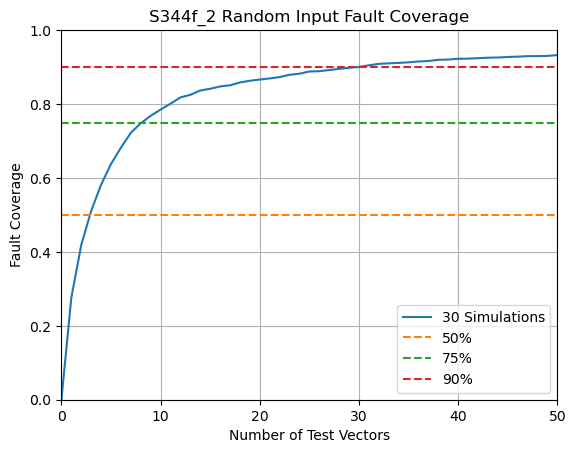

In [281]:
fig = plt.figure()
plt.plot(np.mean(coverages_344, axis=0), label='30 Simulations')
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.5), linestyle='--', label='50%') 
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.75), linestyle='--', label='75%') 
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.9), linestyle='--', label='90%') 
plt.legend()
plt.grid(True)
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.xlabel('Number of Test Vectors')
plt.ylabel('Fault Coverage')
plt.title('S344f_2 Random Input Fault Coverage')
plt.savefig('images/s344f_2_faultcoverage.png')

In [310]:
file = 'Circuit Inputs/s349f_2.txt'
c = Circuit(file)
# print(c.circuit)

In [283]:
tests = ['101000000010101011111111', 
         '111111101010101010001111', ]
# tests = ['101010101010101011111111']
for test in tests:
    c.simulate_faults(test)

Input: 101000000010101011111111
Fault-Free Output:  10100000001010101101111111
Input: 111111101010101010001111
Fault-Free Output:  00011111010010110001010000


In [284]:
coverages = None
n=50

for x in range(30):
    print(x)
    faults = []
    coverage = [0]
    if os.path.isfile('fault_analysis_s349f_2.txt'):
        os.remove('fault_analysis_s349f_2.txt')

    for _ in range(n):
        c.simulate_faults(generate_vector(17), verbose=False)
        with open('fault_analysis_s349f_2.txt') as f:
            lines = [line.rstrip() for line in f]
        for line in lines:
            if 'stuck at' in line:
                fault = (int(line[:line.index('stuck at')].replace(' ', '')), int(line[line.index('stuck at')+8:].replace(' ', '')))
                if fault not in faults:
                    faults.append(fault)
        coverage.append(len(faults)/(2*c.length-4))
        # print(len(faults))

    if coverages is None:
        coverages = np.array(coverage).reshape(1, n+1)
    else:
        coverages = np.vstack((coverages, coverage))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [285]:
coverages_349  = coverages

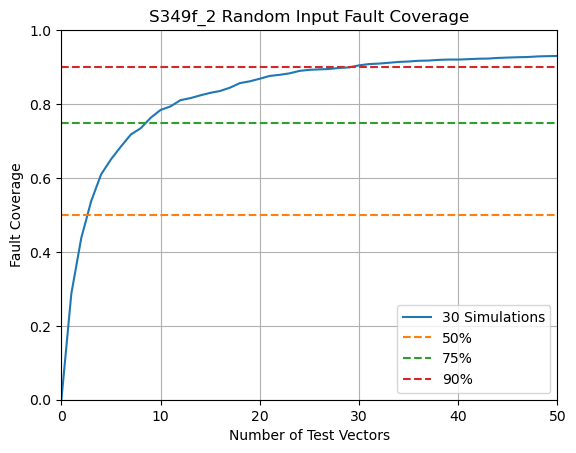

In [286]:
fig = plt.figure()
plt.plot(np.mean(coverages_349, axis=0), label='30 Simulations')
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.5), linestyle='--', label='50%') 
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.75), linestyle='--', label='75%') 
plt.plot(np.linspace(0, 51, 100), np.full((100), 0.9), linestyle='--', label='90%') 
plt.legend()
plt.grid(True)
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.xlabel('Number of Test Vectors')
plt.ylabel('Fault Coverage')
plt.title('S349f_2 Random Input Fault Coverage')
plt.savefig('images/s349f_2_faultcoverage.png')

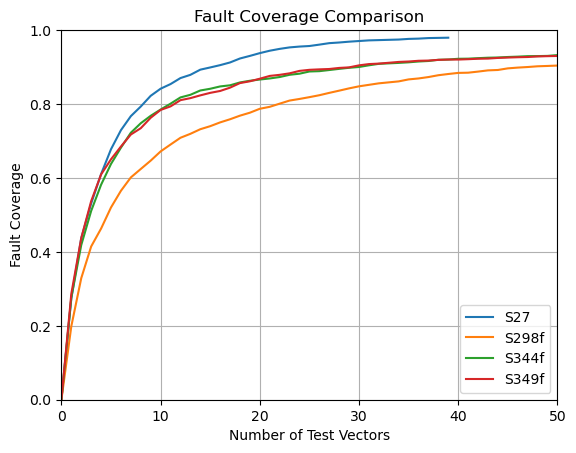

In [305]:
plt.plot(np.mean(coverages_27, axis=0), label='S27')
plt.plot(np.mean(coverages_298, axis=0), label='S298f')
plt.plot(np.mean(coverages_344, axis=0), label='S344f')
plt.plot(np.mean(coverages_349, axis=0), label='S349f')
plt.grid(True)
plt.legend()
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.xlabel('Number of Test Vectors')
plt.ylabel('Fault Coverage')
plt.title('Fault Coverage Comparison')
plt.savefig('images/fault_comparison.png')

In [292]:
coverages_349

array([[0.        , 0.36507937, 0.52116402, ..., 0.96031746, 0.96031746,
        0.96031746],
       [0.        , 0.21693122, 0.33597884, ..., 0.92063492, 0.92328042,
        0.92328042],
       [0.        , 0.26984127, 0.38095238, ..., 0.8968254 , 0.9047619 ,
        0.9047619 ],
       ...,
       [0.        , 0.21428571, 0.47883598, ..., 0.94708995, 0.94708995,
        0.94708995],
       [0.        , 0.36243386, 0.49206349, ..., 0.93650794, 0.94179894,
        0.94179894],
       [0.        , 0.35185185, 0.47883598, ..., 0.94444444, 0.94444444,
        0.94444444]])